In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

import os
import re

import h5py
from tqdm import tqdm

from utils import load_and_format_data_as_df, get_birds_in_time_range, get_velocity_order_parameter, get_variance_ratios, get_number_densities, downsample_A2B

ImportError: cannot import name 'get_variance_ratios' from 'utils' (/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py)

In [2]:
# # this will load the data from the hdf5 file and format it as a pandas dataframe
# # the hdf5 files need to be in the current directory (same as the notebook)
# # ONLY RUN THIS CELL ONCE TO GET THE CSV FILES

# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         if '.hdf5' in filename:
#             print(f'loading {path}')
#             df = load_and_format_data_as_df(path)
#             df.to_csv(f"./{filename.replace('.hdf5', '.csv')}", index=False)
#             print(f'saved under {filename.replace(".hdf5", ".csv")}')

In [3]:
df_A = pd.read_csv('A_nodes.csv', index_col=0)
df_B = pd.read_csv('B_nodes.csv', index_col=0)
df_C = pd.read_csv('C_nodes.csv', index_col=0)

In [4]:
# data encompasses "flock formation, circling, and landing" over a 30 minute period
# ~1800 chimney swift birds
# there are regions reported where the birds are highly correlated - when flying - and less correlated - when landing - as the intention of the study

In [5]:
# range of time in minutes
(df_A.time.max() - df_A.time.min()) / 60, (df_B.time.max() - df_B.time.min()) / 60, (df_C.time.max() - df_C.time.min()) / 60

(8.505727950172396, 9.431653876098322, 8.19263708152597)

In [6]:
# individual time ranges for tracks
# A
df_A.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    24966.000000
mean         7.405351
std          6.848828
min          0.934268
25%          2.535869
50%          5.071738
75%         10.010010
max        100.066733
dtype: float64

In [7]:
# individual time ranges for tracks
# B
df_B.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    78498.000000
mean         6.520097
std          5.619826
min          0.934268
25%          2.435769
50%          4.671338
75%          8.842176
max         59.092426
dtype: float64

In [8]:
# individual time ranges for tracks
# C
df_C.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    39403.000000
mean         4.478242
std          3.859843
min          0.934268
25%          1.968635
50%          3.169837
75%          5.472139
max         42.442442
dtype: float64

In [30]:
# velocity order parameter
vel_order_A = get_velocity_order_parameter(df_A)
vel_order_B = get_velocity_order_parameter(df_B)
vel_order_C = get_velocity_order_parameter(df_C)

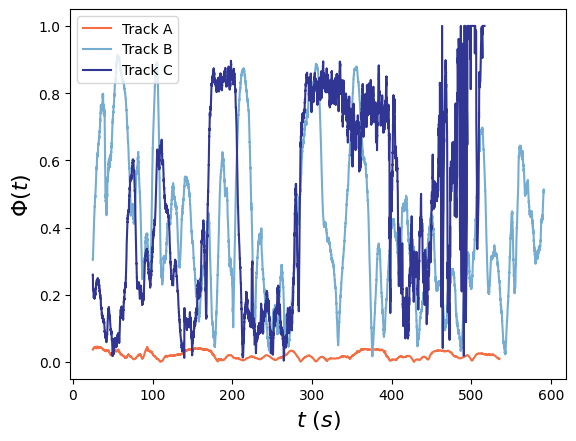

In [59]:
import mdaux
colors = mdaux.getValToColorMap([-1, 0, 1, 2, 3, 4])
plt.plot(np.sort(df_A.time.unique()), vel_order_A, label='Track A', color=colors[0])
plt.plot(np.sort(df_B.time.unique()), vel_order_B, label='Track B', color=colors[3])
plt.plot(np.sort(df_C.time.unique()), vel_order_C, label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.savefig('velocity_order_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
vars_A = get_variance_ratios(df_A)
vars_B = get_variance_ratios(df_B)
vars_C = get_variance_ratios(df_C)

100%|██████████| 4881/4881 [00:08<00:00, 546.13it/s]


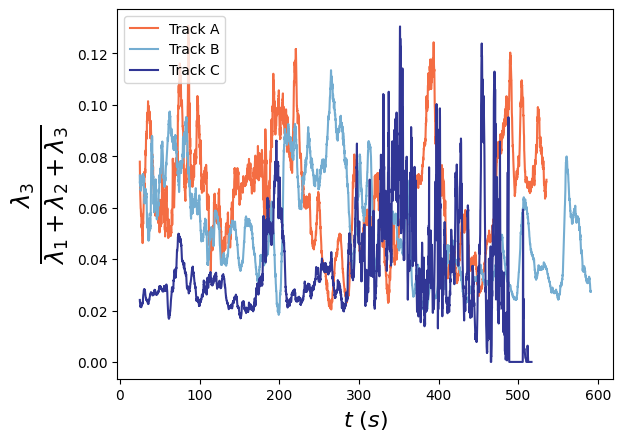

In [109]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(vars_A)), vars_A[:, 2], label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(vars_B)), vars_B[:, 2], label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(vars_C)), vars_C[:, 2], label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('variance_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
# get density
densities_A = get_number_densities(df_A)
densities_B = get_number_densities(df_B)
densities_C = get_number_densities(df_C)

 95%|█████████▍| 4623/4881 [00:09<00:00, 533.96it/s]/var/folders/0b/4bnfdhq15v3cy5c13mgg2z_00000gn/T/ipykernel_64359/472382927.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:09<00:00, 497.97it/s]


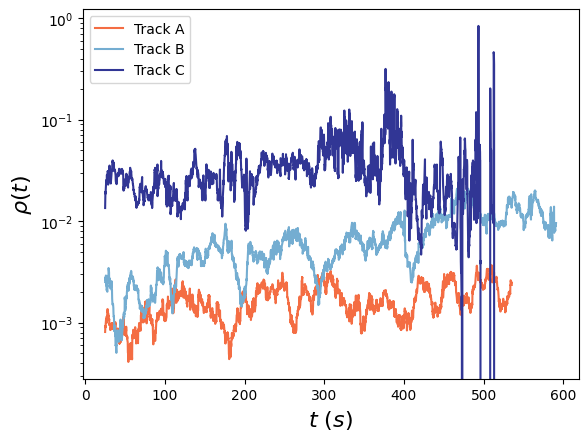

In [131]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(densities_A)), densities_A, label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(densities_B)), densities_B, label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(densities_C[densities_C < 1e6])), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('number_density.png', dpi=300, bbox_inches='tight')

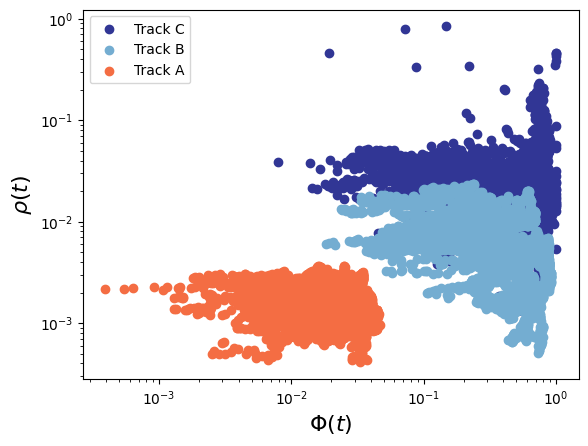

In [151]:
# correlation between velocity order parameter and density
plt.scatter(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6]), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, densities_B), densities_B, label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, densities_A), densities_A, label='Track A', color=colors[0])
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('velocity_order_parameter_vs_density.png', dpi=300, bbox_inches='tight')

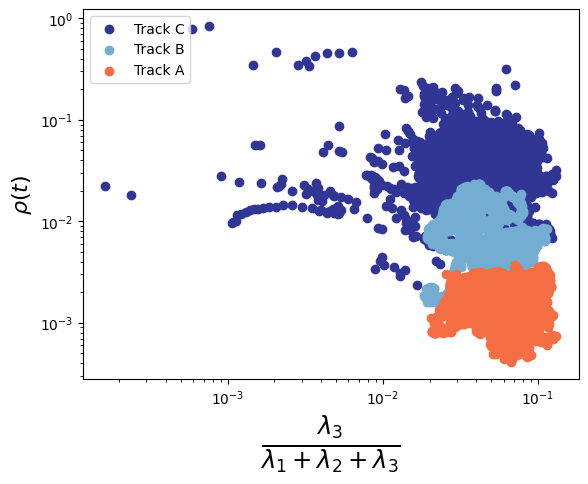

In [164]:
# correlation between velocity order parameter and density
plt.scatter(vars_C[:, 2][densities_C < 1e6], densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(vars_B[:, 2], densities_B, label='Track B', color=colors[3])
plt.scatter(vars_A[:, 2], densities_A, label='Track A', color=colors[0])
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('variance_ratios_vs_density.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, '$\\frac{\\lambda_3}{\\lambda_1 + \\lambda_2 + \\lambda_3}$')

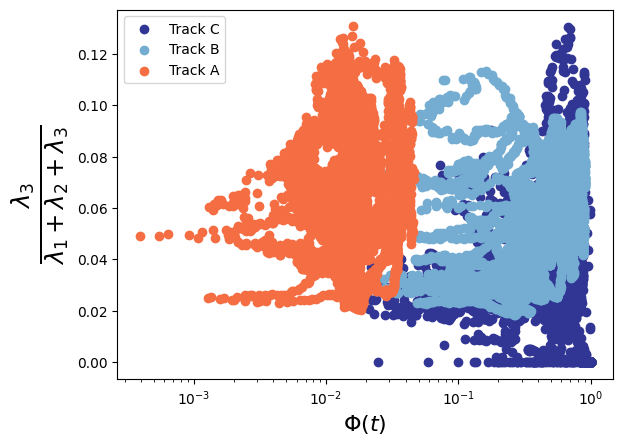

In [170]:
plt.scatter(downsample_A2B(vel_order_C, vars_C[:, 2]), vars_C[:, 2], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, vars_B[:, 2]), vars_B[:, 2], label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, vars_A[:, 2]), vars_A[:, 2], label='Track A', color=colors[0])
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('velocity_order_parameter_vs_variance_ratios.png', dpi=300, bbox_inches='tight')

In [60]:

df = get_birds_in_time_range(df_A, time_start=40, time_end=42.5)
